### 정보 이득(IG, Information Gain) 최대화

내가 이해한 대로 풀어보자면 루트 노드의 불순도는 최대 1이다. 모든 클래스가 균등하게 섞여 있을 경우다. 루트 노드를 이진 트리로 나눌 때는 정보이득이 높은 기준을 선택한다. 정보 이득은 부모 불순도에서 자식 불순도의 합을 뺀 값이다. 자식 불순도를 합하는 이유는 자식이 둘이기 때문이다. 자식 불순도가 낮을수록, 즉 자식의 클래스가 한쪽으로 쏠려 순수해질수록 정보 이득이 높다. 

불순도를 측정하는 방법은 엔트로피, 지니 불순도, 분류 오차가 있다. 

$IG(D_p, f) = I(D_p)-\sum\limits_{j=1}^m \frac{N_j}{N_p}I(D_j) = I(D_p) -\frac{N_{left}}{N_p}I(D_{left})-\frac{N_{right}}{N_p}I(D_{right})$

<img src="images/ic.jpeg" width="50%">

**정보 이득(부모 불순도 - 자식 불순도 합)이 큰 쪽으로 분할**한다. 정보 이득은 자식 노드의 불순도가 작을수록 커진다. 

#### 엔트로피

$I_H(t)=-\sum\limits_{i=1}^cp(i|t)log_2p(i|t)$
- $p(i|t)$ : 특정 노드 t에서 클래스 i에 속한 샘플 비율
- 한 노드이 모든 샘플이 같으면 0. 클래스 분포가 균등하면 최대
- $p(i|t)=1$ or $p(i|t)=0$ => 엔트로피=0 : t노드의 모든 샘플이 i이거나(1) i가 아니면(0) 엔트로피는 0
- $p(i=1|t)=0.5$ and $p(i=0|t)=0.5$ => 엔트로피=1 : t노드의 샘플의 절반이 1이고 나머지 절반이 0이면 엔트로피는 1

:::{.callout-warning}
수식 맨 앞에 마이너스는 왜 붙었을까?
log 계산에서 진수가 0 ~ 1 사이 값은 음수가 나오기 때문에 이를 양수로 바꾸기 위해 붙인 건 아닐까?
확률은 1이 최대이기 때문에 그 이상은 고려할 필요 없는 건 아닐까?
:::

#### 지니 불순도

$I_G(t)=\sum\limits_{i=1}^cp(i|t)(1-p(i|t))=1-\sum\limits_{i=1}^cp(i|t)^2$
- 잘못 분류될 확률을 최소화하기 위한 기준
- 지니 불순도는 클래스가 완벽하게 섞여 있을 때 최대. 이진 분류에서 두 클래스가 반반일 때 = 0.5

#### 분류 오차

$I_E = 1 - max(p(i|t))$
- 큰 쪽만 계산

[좀더 쉬운 설명](https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-4-%EA%B2%B0%EC%A0%95-%ED%8A%B8%EB%A6%ACDecision-Tree){target=_blank}

In [10]:
import math
math.log2(0.5)

-1.0

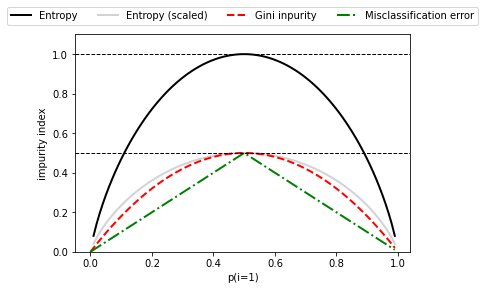

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

def gini(p):
    return (p)*(1-p) + (1-p)*(1 - (1-p))

def entropy(p):
    return - p*np.log2(p) - (1-p)*np.log2((1-p))

def error(p):
    return 1 - np.max([p, 1-p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x] # 엔트로피
sc_ent = [e*0.5 if e else None for e in ent] # 지니 불순도가 엔트로피와 분류 오차의 중간인지 확인
err = [error(i) for i in x] # 분류 오차

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
                          ['Entropy', 'Entropy (scaled)', 'Gini inpurity', 'Misclassification error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')
plt.show()

### 결정 트리 만들기

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    markers = ('s', 'x', 'o', '^', 'V')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() -1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() -1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl,
                    edgecolor='black')
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0], X_test[:, 1],
                    facecolors='None', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o', s=100, label='test set')

In [13]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('클래스 레이블:', np.unique(y))


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

X_train_01_subset = X_train[(y_train == 0 | (y_train == 1))]
y_train_01_subset = y_train[(y_train == 0 | (y_train == 1))]


sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

클래스 레이블: [0 1 2]


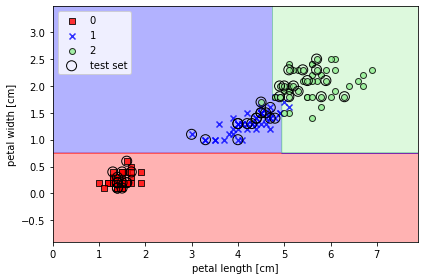

In [22]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
tree_model.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, classifier=tree_model, test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 결정 트리 모델 시각화

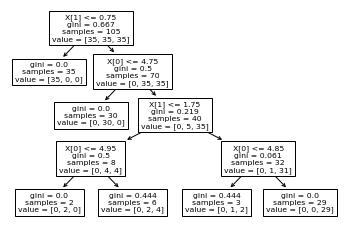

In [15]:
from sklearn import tree

tree.plot_tree(tree_model)
plt.show()

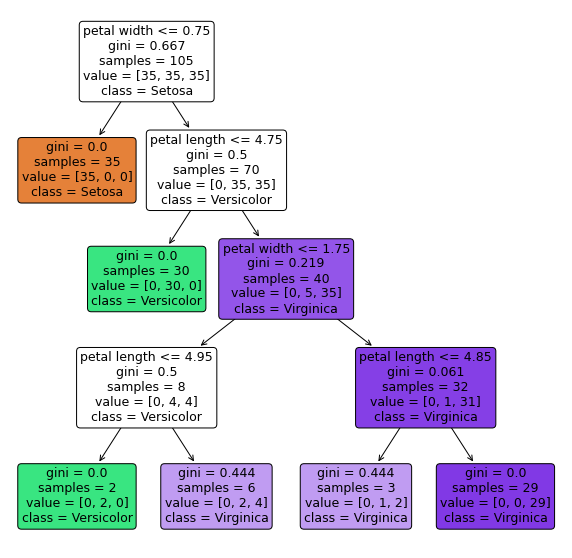

In [17]:
plt.figure(figsize=(10,10))
tree.plot_tree(tree_model,
               impurity=True,
               filled=True, 
               rounded=True,
               class_names=['Setosa', 
                            'Versicolor',
                            'Virginica'],
               feature_names=['petal length', 
                              'petal width'])
plt.show()

In [19]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree_model,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('./images/tree.png')

True

[sklearn Post Pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py){target=_blank}